## 모델 생성

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.4
Running on ArviZ v0.11.4


pymc3의 확률모델 생성의 경우 with pm.Model() as model: 로 작동한다.

In [3]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

다음과 같이 파라미터 전달을 통해 확률분포 모델 생성가능

In [4]:
model.basic_RVs

[mu ~ Normal, obs ~ Normal]

In [5]:
model.free_RVs

[mu ~ Normal]

In [6]:
model.observed_RVs

[obs ~ Normal]

mu의 경우 자유도가 존재하고, obs의 경우 mu가 결정되면 생기는 모델이므로  
obs 분포에 대해 hyper-parameter가 mu의 분포에 대한 모수이다.  
즉 free_RVs하면 mu가 나오고, observed_RVs하면 obs에 대한 정보가 나온다.

In [7]:
model.logp({"mu": 0})

array(-138.17885585)

logp의 경우 모델에서 특정 확률분포의 log-probability를 구하는데, log-probability는 그냥 확률보다 stable하다.(그냥 확률의 경우 곱하면 계속 0으로 수렴)

## 확률분포 다루기

In [8]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

In [9]:
x.logp({'x':0})

array(-0.91893853)

In [10]:
with pm.Model():
    obs = pm.Normal("x", mu=0, sigma=1, observed=np.random.randn(100))

다음과 같이 unobserved rv를 활용하여 observed rv 생성가능

In [11]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x ** 2
    sined = pm.math.sin(x)

변수들끼리 대수연산도 자유로우나 자동으로 저장이 안됨.  
저장하고 싶으면 Deterministic 이용

In [12]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

Bounded Random Variables - mean이 0고, 어느 [a,b] 구간에 정의된 확률변수 X

Pymc3의 경우 Bounded RV를 Unbounded RV로 바꿔준다.

In [13]:
with pm.Model() as model:
    x = pm.Uniform("x", lower=0, upper=1)

In [14]:
model.free_RVs

[x_interval__ ~ TransformedDistribution]

In [15]:
model.deterministics

[x ~ Uniform]

In [16]:
with pm.Model() as model:
    x = pm.Uniform("x", lower=0, upper=1, transform=None)

print(model.free_RVs)

[x ~ Uniform]


그러나 다음과 같이 변환도 안해줄수 있다.

그러나 distribution.transforms 메서드 이용시 custom한 변환을 적용가능

In [17]:
import pymc3.distributions.transforms as tr

with pm.Model() as model:
    # use the default log transformation
    x1 = pm.Gamma("x1", alpha=1, beta=1)
    # specify a different transformation
    x2 = pm.Gamma("x2", alpha=1, beta=1, transform=tr.log_exp_m1)

print("The default transformation of x1 is: " + x1.transformation.name)
print("The user specified transformation of x2 is: " + x2.transformation.name)

The default transformation of x1 is: log
The user specified transformation of x2 is: log_exp_m1


Pymc3의 경우 transformed distribution을 생성할수 있다.  
transform kwarg에 메서드를 전달해주면 된다.

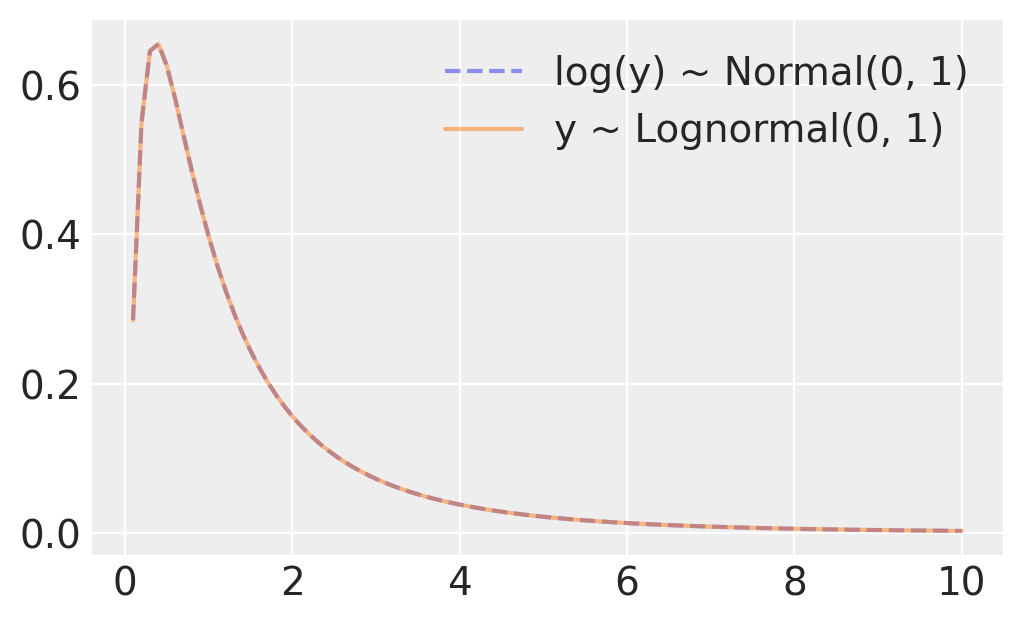

In [18]:
class Exp(tr.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)


with pm.Model() as model:
    x1 = pm.Normal("x1", 0.0, 1.0, transform=Exp())
    x2 = pm.Lognormal("x2", 0.0, 1.0)

lognorm1 = model.named_vars["x1_exp__"]
lognorm2 = model.named_vars["x2"]

_, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.linspace(0.0, 10.0, 100)
ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    "--",
    alpha=0.5,
    label="log(y) ~ Normal(0, 1)",
)
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha=0.5,
    label="y ~ Lognormal(0, 1)",
)
plt.legend();

pymc3에서 형성된 lognormal 분포와 커스텀으로 만든 lognormal 분포가 똑같다.  
그리고 이러한 걸 이용해서 ordered distribution도 만들 수 있다.

In [19]:
Order = tr.Ordered()
Logodd = tr.LogOdds()
chain_tran = tr.Chain([Logodd, Order])

Logodd로 만든 뒤 ordered 분포를 만듬.

$x_1,x_2 ~ Uniform(0,1)$  
$x_1 < x_2$

In [20]:
with pm.Model() as m0:# 0.0 : 시작점, 1.0 : 끝점
    x = pm.Uniform("x", 0.0, 1.0, shape=2, transform=chain_tran, testval=[0.1, 0.9])
    trace = pm.sample(5000, tune=1000, progressbar=False, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 49 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [21]:
trace.varnames

['x_logodds+ordered__', 'x']

C:\Users\User\AppData\Local\Temp\ipykernel_25404\3087786998.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


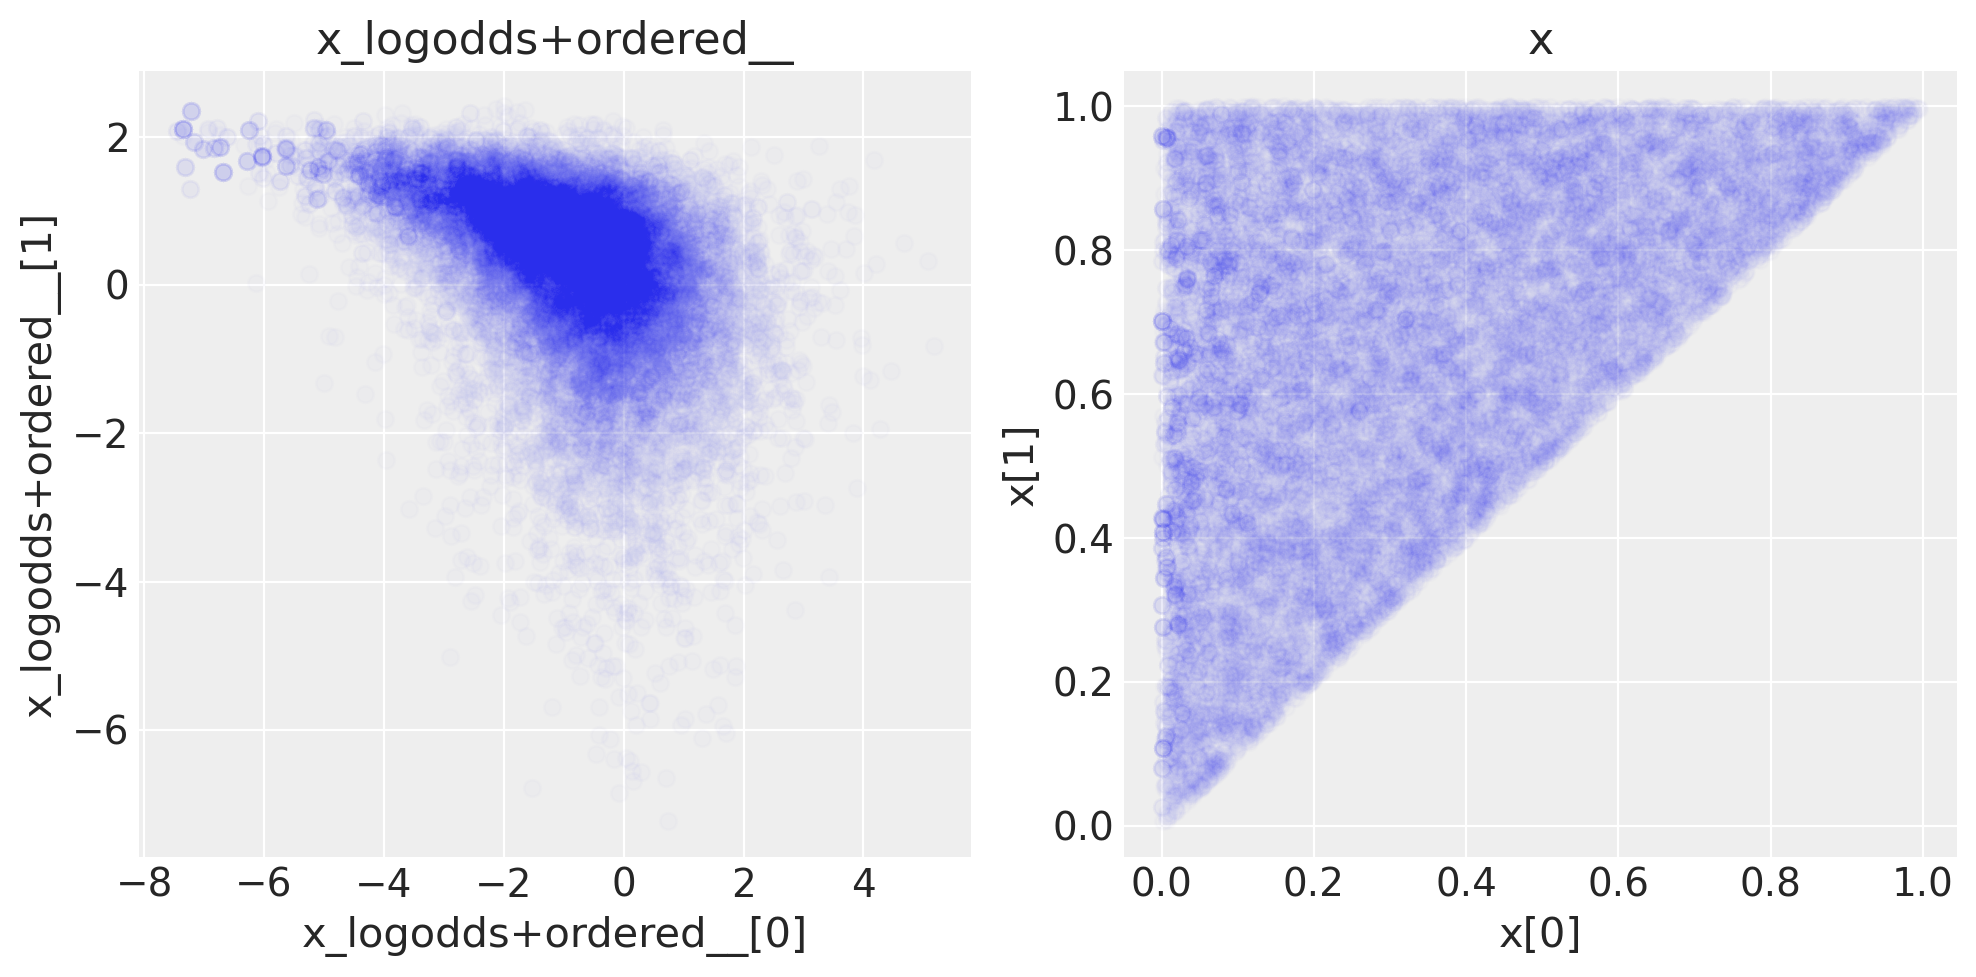

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(trace.varnames):
    ax[ivar].scatter(trace[varname][:, 0], trace[varname][:, 1], alpha=0.01)
    ax[ivar].set_xlabel(varname + "[0]")
    ax[ivar].set_ylabel(varname + "[1]")
    ax[ivar].set_title(varname)
plt.tight_layout()

높은 차원의 Random Variable도 만들 수 있다.

In [23]:
with pm.Model():
    # bad:
    x = [pm.Normal(f"x_{i}", mu=0, sigma=1) for i in range(10)]

In [24]:
with pm.Model() as model:
    # good:
    x = pm.Normal("x", mu=0, sigma=1, shape=10)

두 분포 똑같지만, 밑의 코드가 더 직관적이다.

In [25]:
with model:
    y = x[0] * x[1]  # full indexing is supported
    x.dot(x.T)  # Linear algebra is supported

다음과 같은 연산도 가능하다

In [26]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1, shape=5)

x.tag.test_value

array([0., 0., 0., 0., 0.])

In [27]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1, shape=5, testval=np.random.randn(5))

x.tag.test_value

array([-1.62633564,  0.14875477,  0.44284343, -0.68387066, -0.76804675])

Pymc3의 경우 자동으로 test 값도 만든다.

## Inference

pymc의 경우 pm.sample()을 통해 분포에서 샘플링을 할 수 있다.

In [28]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 37 seconds.


2000개의 값을 샘플링하고, parameter 조정을 위해 1500번의 iteration을 추가로 시행

In [29]:
idata.posterior.dims

Frozen({'chain': 4, 'draw': 2000})

discard_tuned_samples=False를 줄 경우 tune에 이용된 sample도 보관 가능

In [30]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(cores=4, chains=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [mu]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 51 seconds.


cores와 chains를 통해 multiple chain도 run 가능

In [31]:
idata.posterior["mu"].shape

(6, 1000)

In [32]:
# get values of a single chain
idata.posterior["mu"].sel(chain=1).shape

(1000,)

single chain의 값들도 따로 가져오기 가능

pymc3의 경우 기본적으로 sampling 방법이 NUTS 샘플링인데 다른 샘플링도 사용가능하다

In [33]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'DEMetropolisZMLDA',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'MLDA',
 'Metropolis',
 'MetropolisMLDA',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PGBART',
 'PoissonProposal',
 'RecursiveDAProposal',
 'Slice',
 'UniformProposal']

In [34]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
The number of effective samples is smaller than 25% for some parameters.


Metropolis 샘플링을 이용

In [35]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    idata = pm.sample(10000, step=[step1, step2], cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 50 seconds.
The number of effective samples is smaller than 25% for some parameters.


다변수 분포의 경우 각각의 변수들에 대해 다른 샘플링도 적용가능

이제 샘플링을 했으면 샘플링한 결과들에 대해 해석을 해야한다.

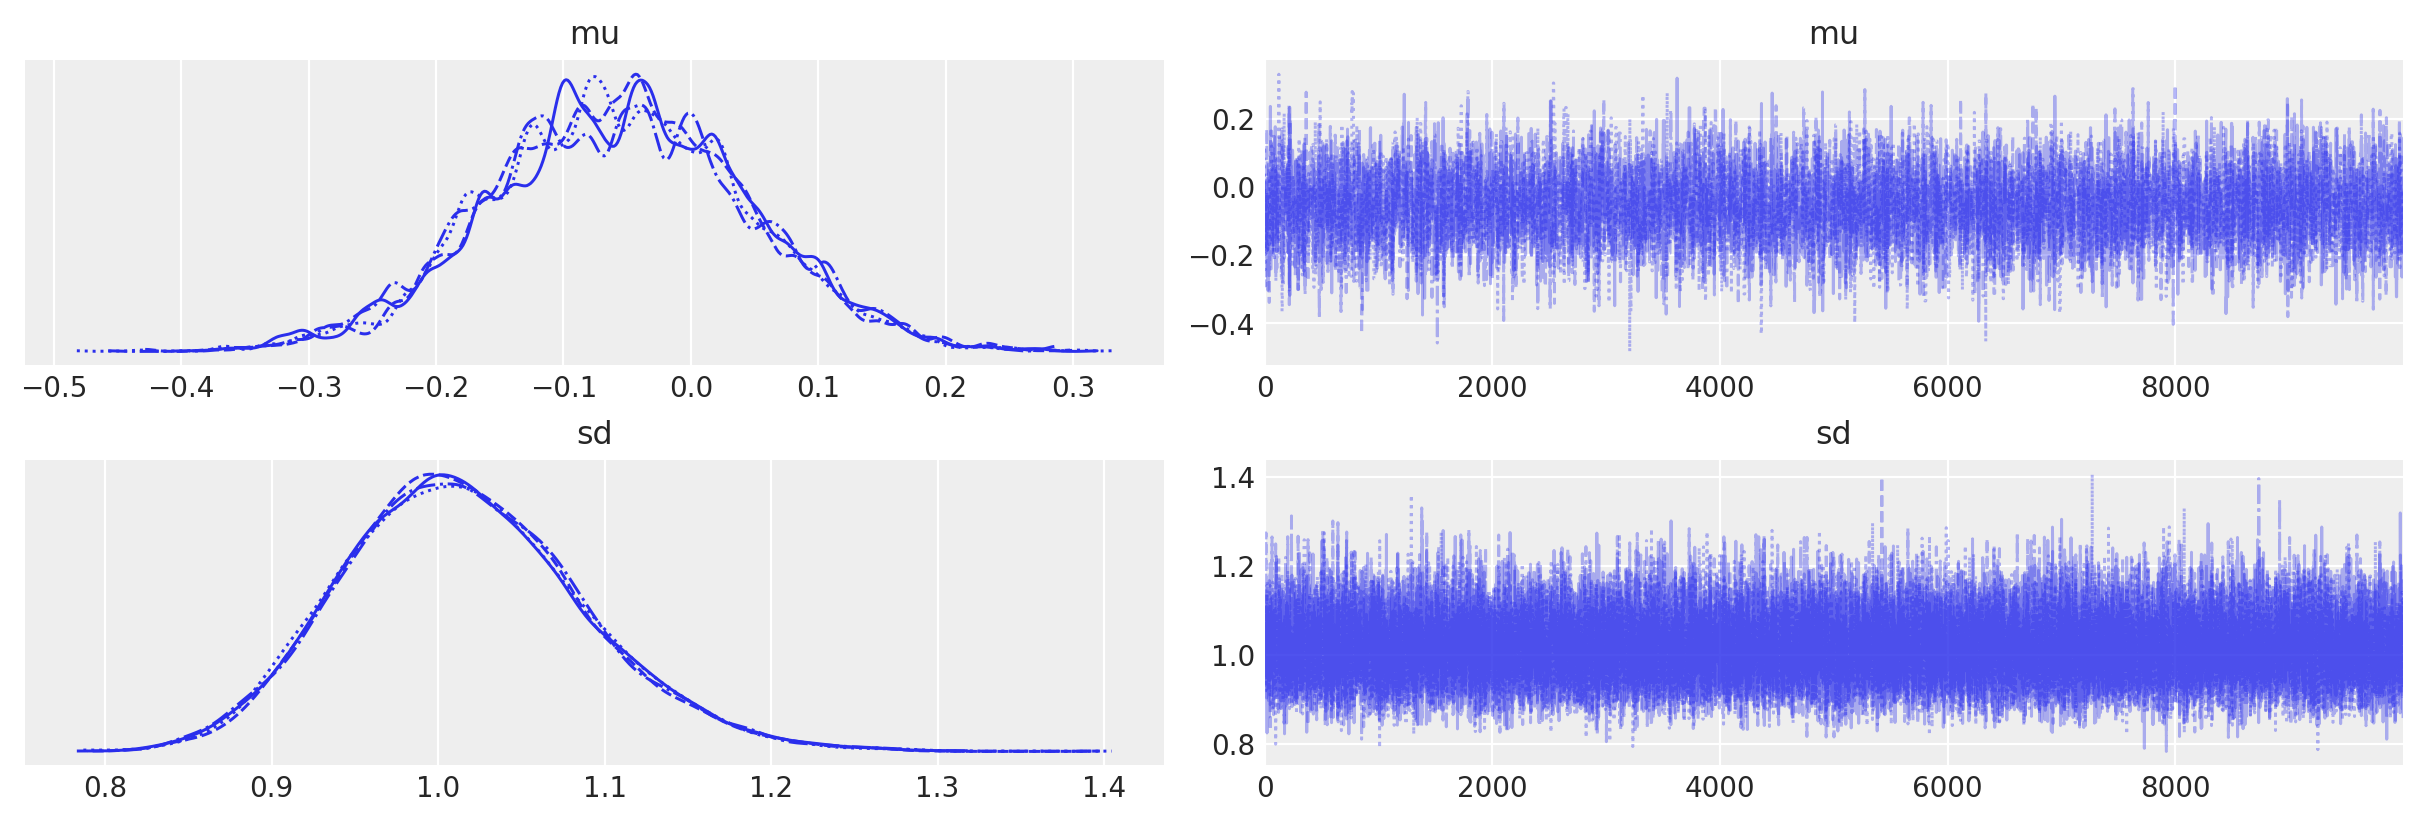

In [36]:
az.plot_trace(idata);

샘플링한 결과에 대해 보여준다.

In [37]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.057,0.101,-0.247,0.134,0.001,0.001,5704.0,6223.0,1.0
sd,1.015,0.072,0.882,1.151,0.000,0.000,37985.0,28825.0,1.0


말그대로 요약본이다.

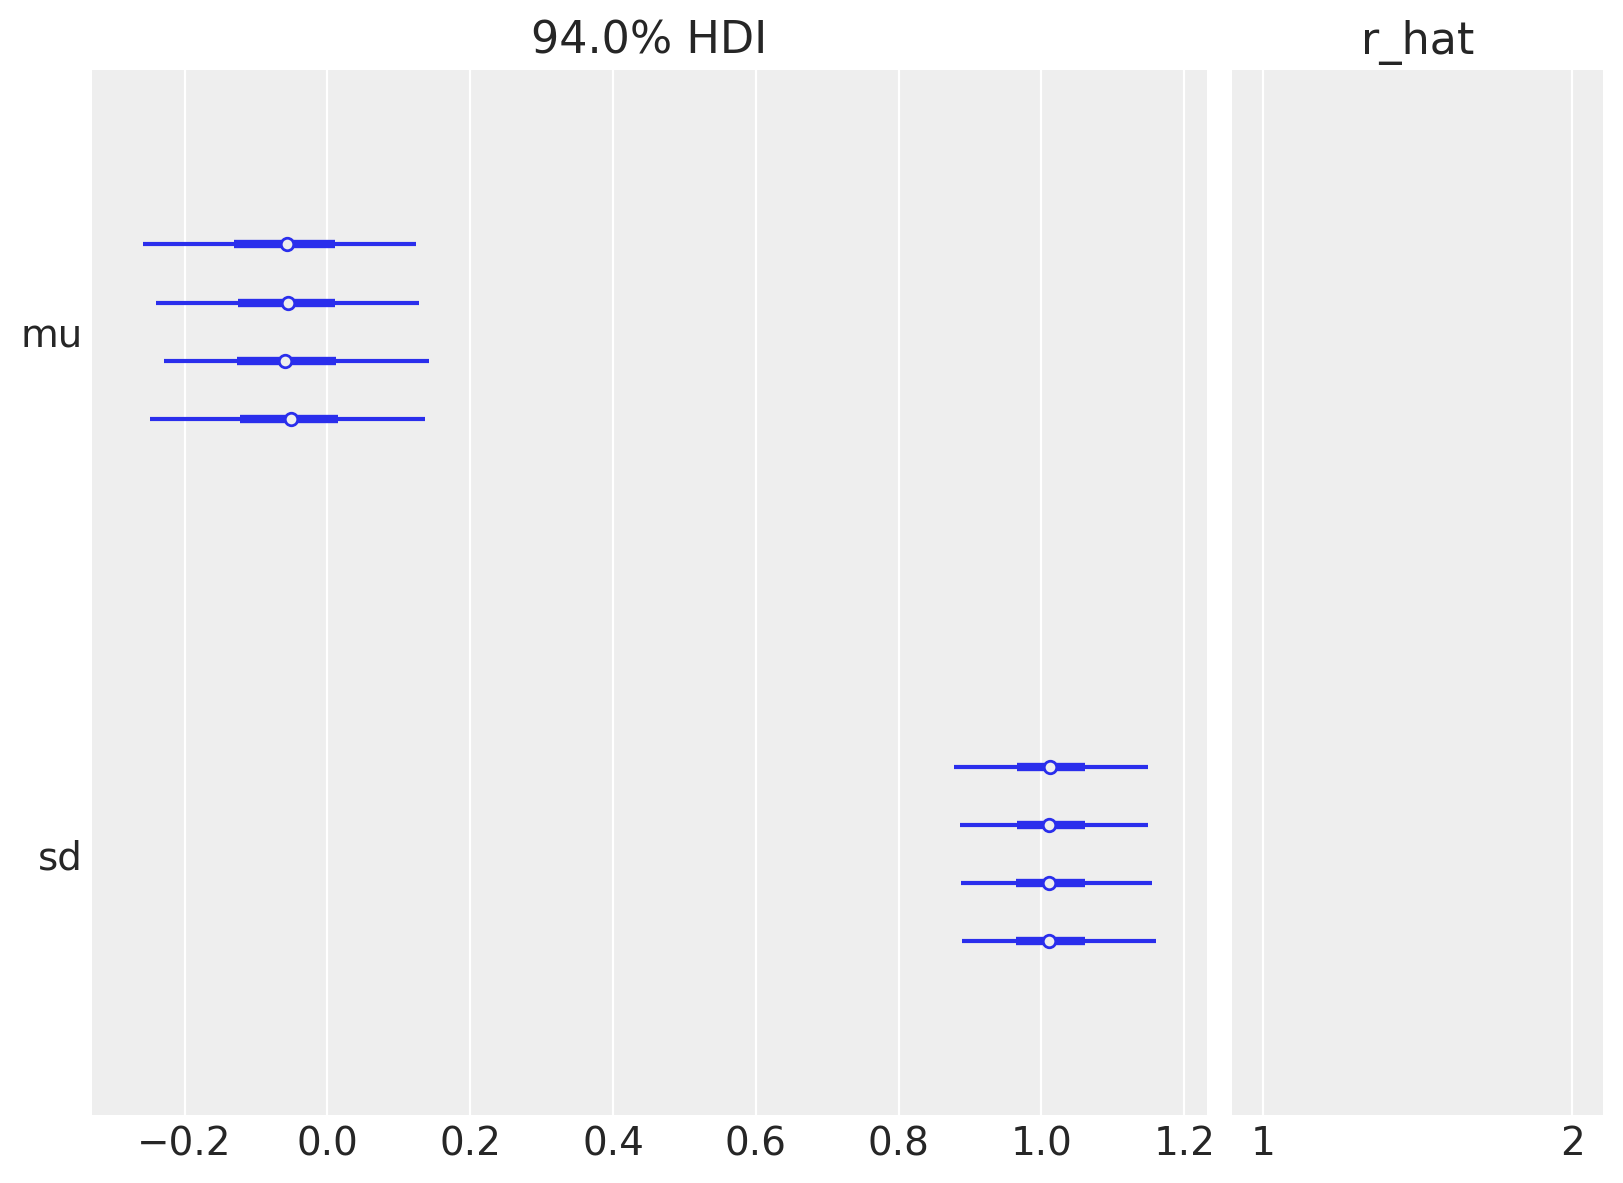

In [38]:
az.plot_forest(idata, r_hat=True);

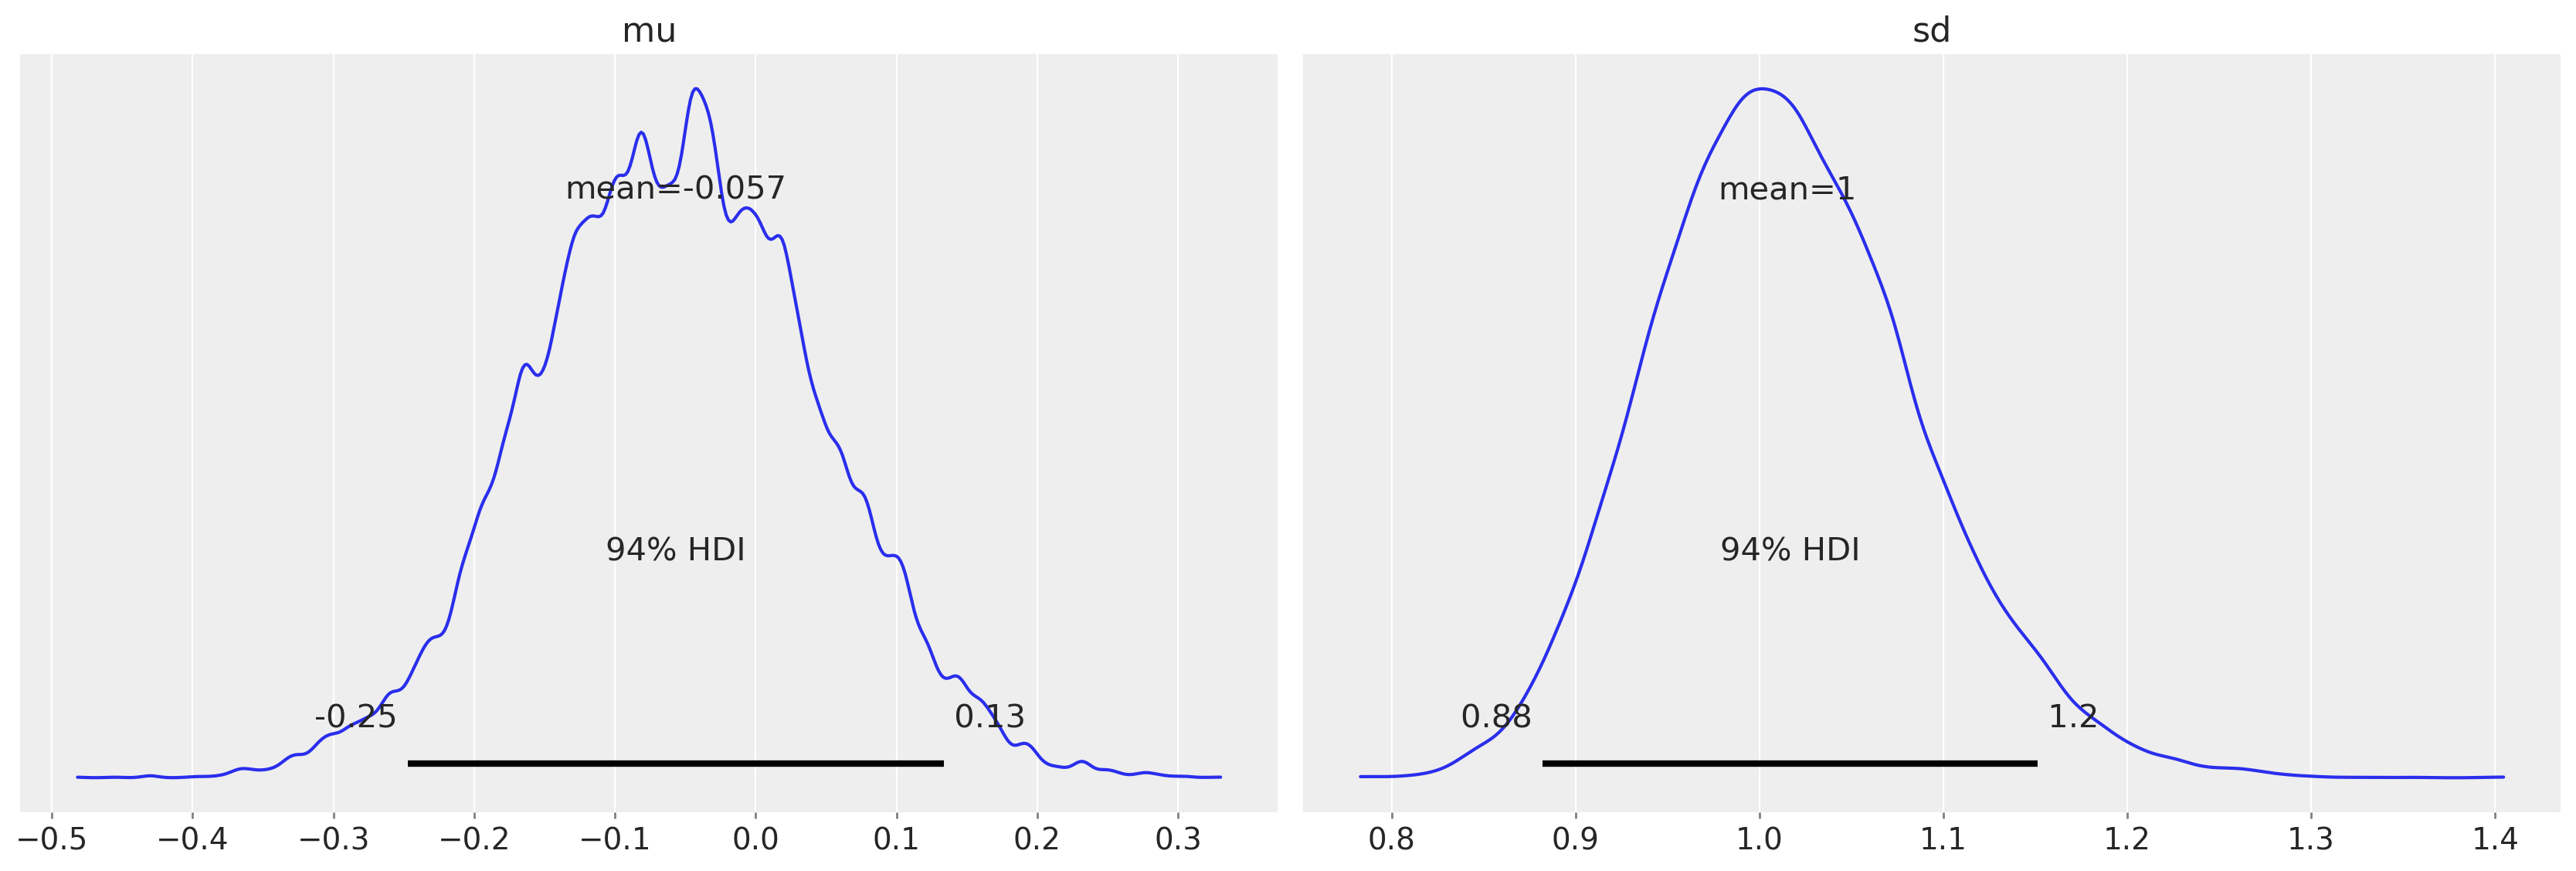

In [39]:
az.plot_posterior(idata);

데이터로 생성한 posterior도 그릴 수 있다.

high-dimension 모델의 경우 energy_plot도 그릴 수 있다.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


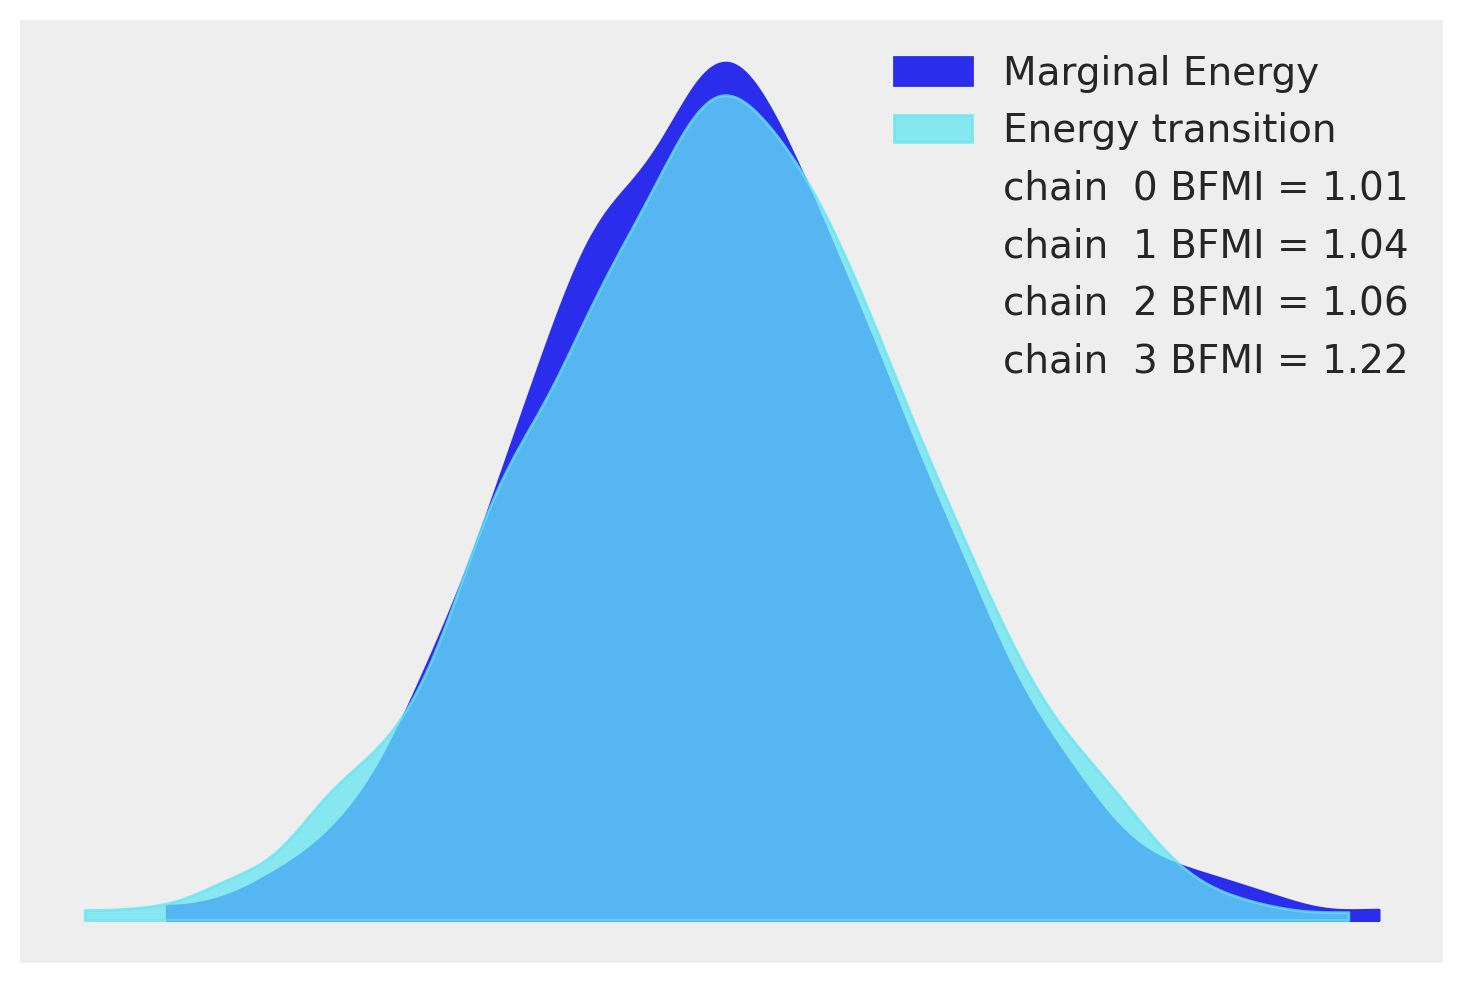

In [40]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1, shape=100)
    idata = pm.sample(cores=4, return_inferencedata=True)

az.plot_energy(idata);

pymc는 Variational Inference도 제공한다.  
변분베이즈 방법 - 복잡한 모델에 대해 변분 원리를 이용하여 분포를 근사한다.  
그러나 정확도가 낮고, 편향된 결과를 불러 일으킬 가능성이 높아 잘 사용은 안한다.

In [41]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    approx = pm.fit()

Finished [100%]: Average Loss = 153.22


앞선 코드에 의하면 pm.sampling()을 통해 결정되는 확률분포에서 샘플링을 하는 방법이지만, Variational Inference를 이용할경우 확률분포를 모델링하는 작업이 필요하여 pm.fit()을 이용

In [42]:
approx.sample(500)

<MultiTrace: 1 chains, 500 iterations, 3 variables>

In [43]:
mu = pm.floatX([0.0, 0.0])
cov = pm.floatX([[1, 0.5], [0.5, 1.0]])
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    approx = pm.fit(method="fullrank_advi")

Finished [100%]: Average Loss = 0.0065707


다음과 같은 코드를 이용하여 Fullrank-Automatic Differentiation Variational Inference도 가능

In [44]:
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    approx = pm.FullRankADVI().fit()

Finished [100%]: Average Loss = 0.011343


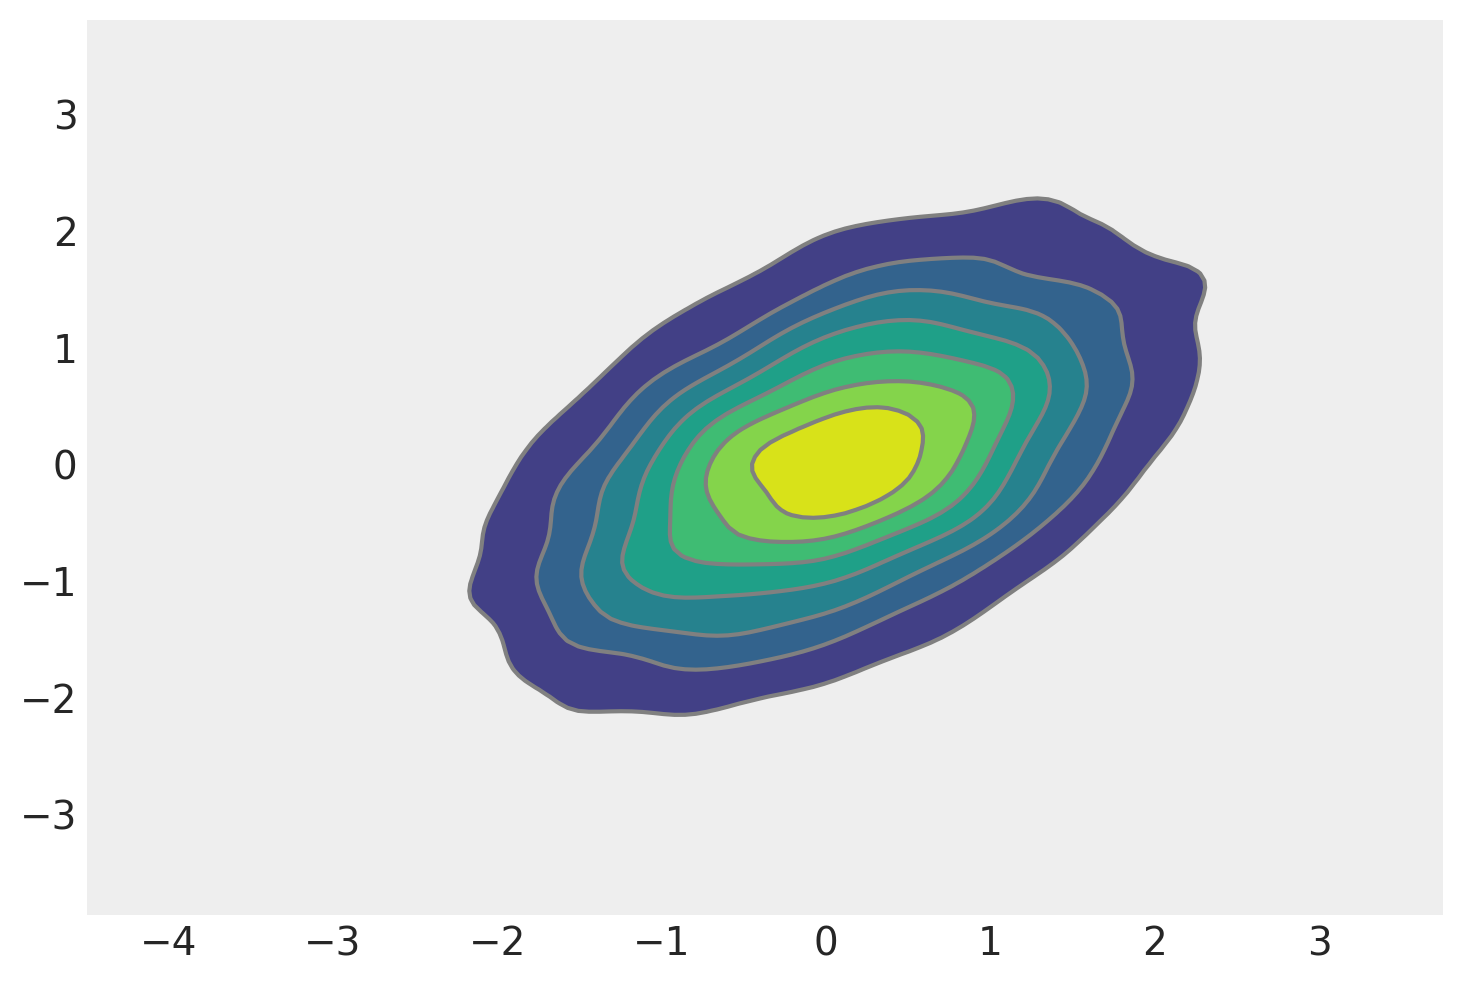

In [45]:
plt.figure()
trace = approx.sample(10000)
az.plot_kde(trace["x"][:, 0], trace["x"][:, 1]);

In [46]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])
with pm.Model() as model:
    pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.0))

또 많이 이용되는 것이 Stein Variational Gradient Descent 인데, posterior를 측정하기 위해 particle을 이용한다.

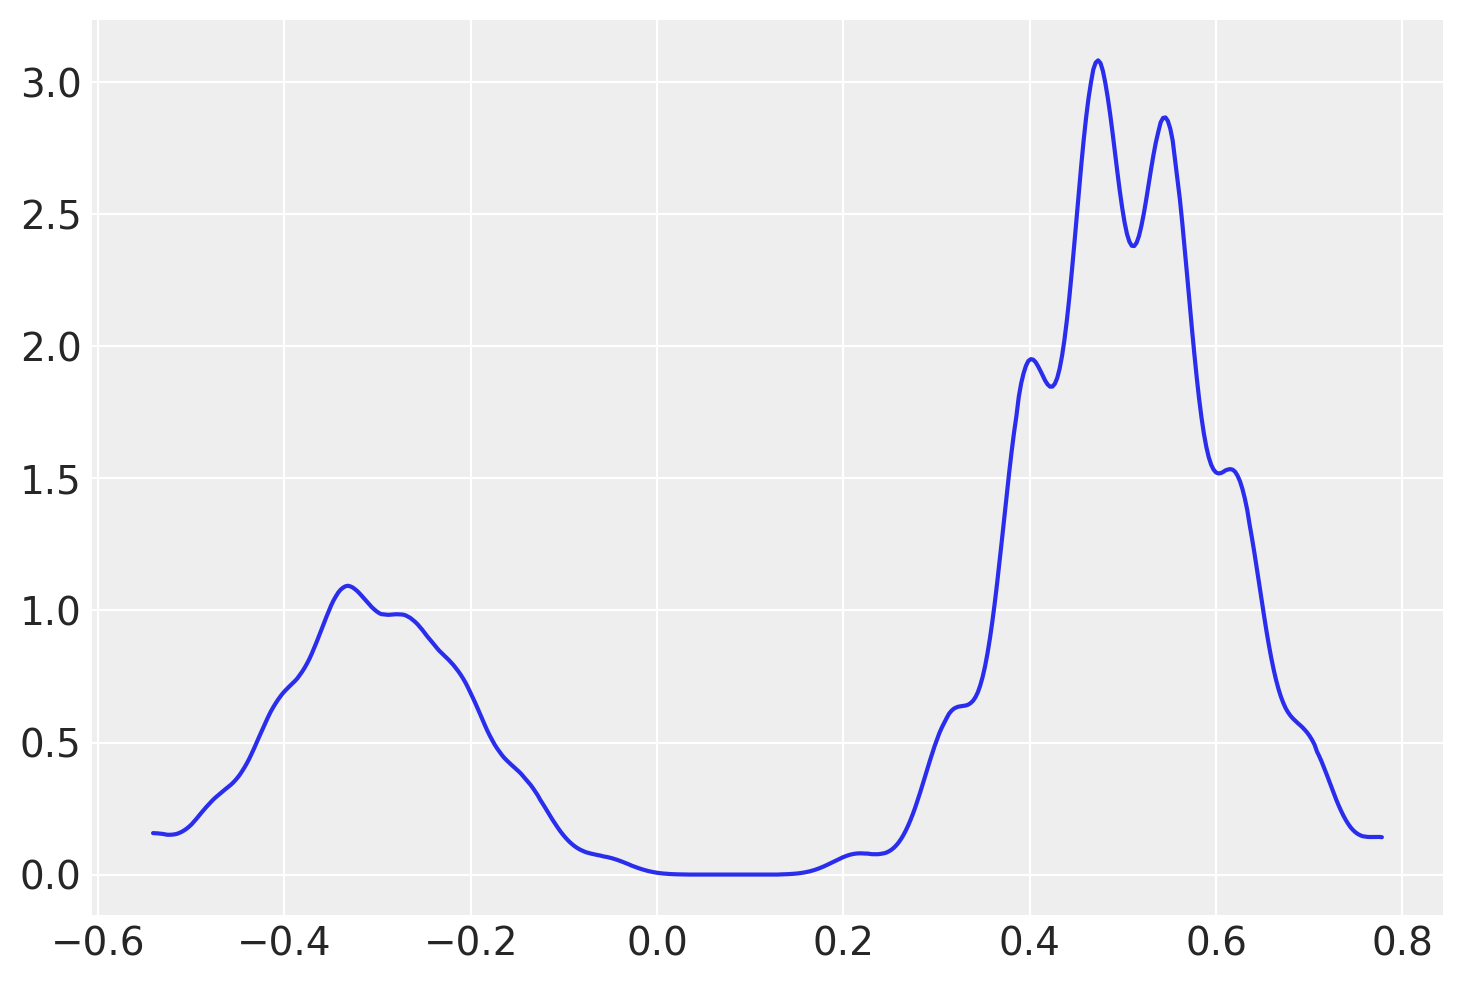

In [47]:
plt.figure()
trace = approx.sample(10000)
az.plot_dist(trace["x"]);

## Posterior Predictive Sampling

pymc의 경우 데이터에서 생성된 Posterior 기반 Prediction도 가능

In [48]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


In [49]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)

# 예측한 데이터를 posterior 데이터에 병합도 가능
az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

Got error No model on context stack. trying to find log_likelihood in translation.


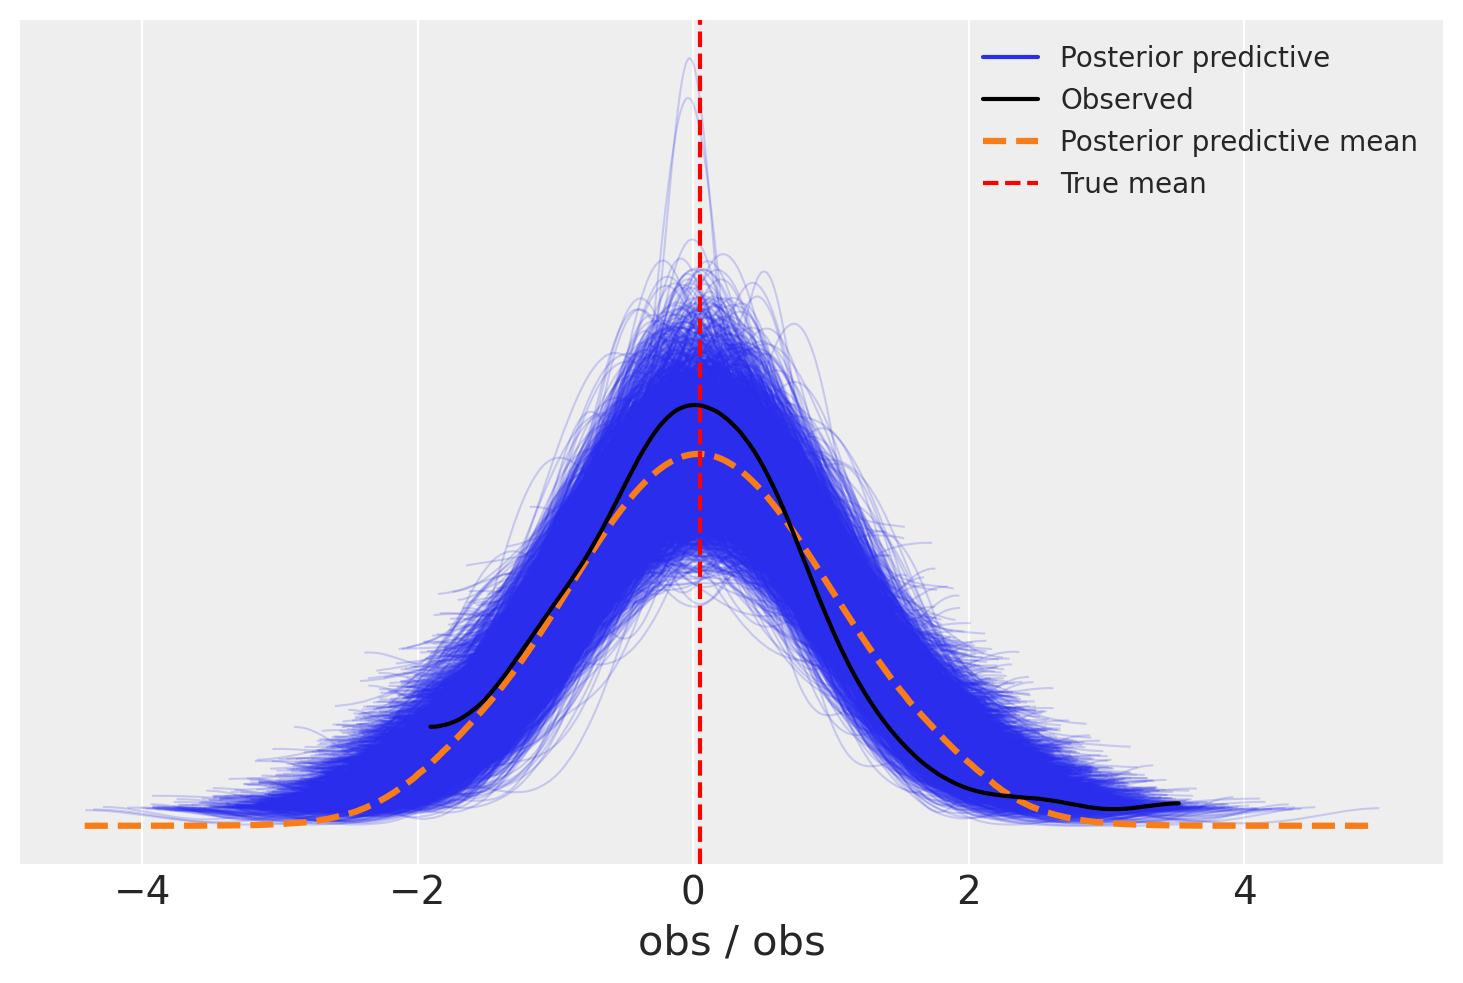

In [50]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

데이터 기반으로 Unseen Data 예측하기

In [51]:
x = np.random.randn(100)
y = x > 0

In [52]:
with pm.Model() as model:
    # shared 변수를 만들어 나중에 바꿀 수 있도록 설정
    x_shared = pm.Data("x_obs", x)
    y_shared = pm.Data('y_obs', y)
    
    coeff = pm.Normal('x', mu=0, sigma = 1)
    logistic = pm.math.sigmoid(coeff*x_shared)
    pm.Bernoulli("obs", p=logistic, observed = y_shared)
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8837638402872752, but should be close to 0.8. Try to increase the number of tuning steps.


In [53]:
with model:
    # 데이터의 값을 바꾸고, 데이터를 공유
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # use dummy values with the same shape:
            "y_obs": [0, 0, 0],
        }
    )

    post_pred = pm.sample_posterior_predictive(idata.posterior)

In [54]:
post_pred["obs"].mean(axis=0)

array([0.0185 , 0.49425, 0.97725])